In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import cmweather

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
ds = xr.open_dataset('/home/alfonso/Downloads/CAMP2Ex-APR3-L2Znad_P3B_20190916_R2.nc')

In [3]:
origin = f'{ds.time.long_name[14:]}'
ds['Time'] = pd.to_datetime(ds.time ,unit='s', origin=origin)
ds['Alt_range'] = ds.alt_range.values / 1000

In [4]:
ds = ds.sel(Alt_range=slice(0, 8))

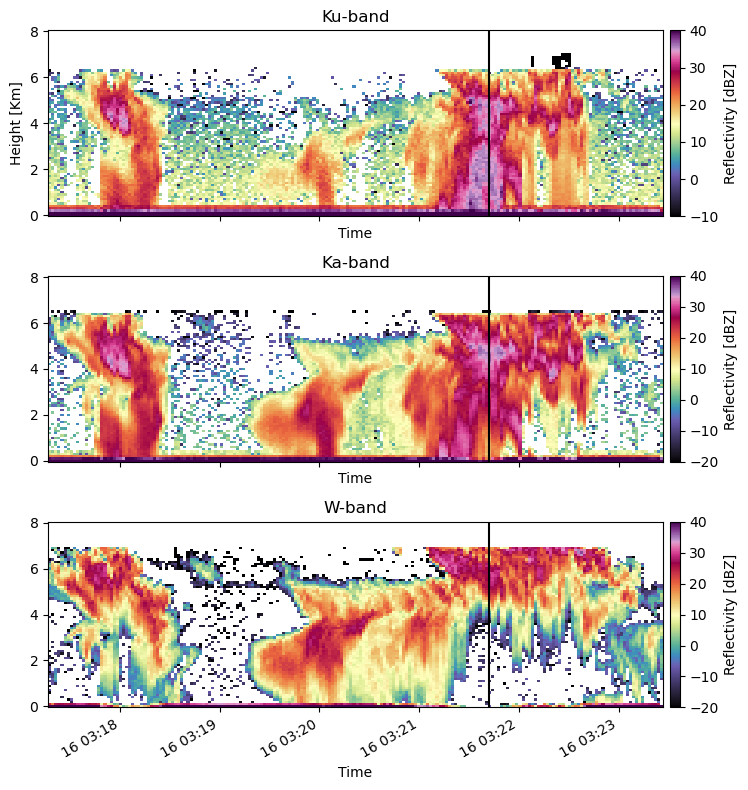

In [5]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

sc = ds['lores_zhh14'].isel(Time=range(8100, 8300)).T.plot(vmin=-10, vmax=40, cmap='ChaseSpectral', ax=ax, add_colorbar=False)
sc1 = ds['lores_zhh35'].isel(Time=range(8100, 8300)).T.plot(vmin=-20, vmax=40, cmap='ChaseSpectral', ax=ax1, add_colorbar=False)
sc2 = ds['hi2lo_z95n'].isel(Time=range(8100, 8300)).T.plot(vmin=-20, vmax=40, cmap='ChaseSpectral', ax=ax2, add_colorbar=False)

ax.axvline(ds.Time.sel(Time='2019-09-16 03:21:42').isel(Time=0).values, 0, 150, c='k')
ax.set_title('Ku-band')
ax.set_ylabel("Height [Km]")

ax1.axvline(ds.Time.sel(Time='2019-09-16 03:21:42').isel(Time=0).values, 0, 150, c='k')
ax1.set_title('Ka-band')
ax1.set_ylabel("")
ax2.axvline(ds.Time.sel(Time='2019-09-16 03:21:42').isel(Time=0).values, 0, 150, c='k')
ax2.set_title('W-band')
ax2.set_ylabel("")

x_ku = ds['lores_zhh14'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
x_ka = ds['lores_zhh35'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
x_w = ds['hi2lo_z95n'].sel(Time='2019-09-16 03:21:42').isel(Time=0)


plt.tight_layout()
fig.colorbar(sc, ax=ax, pad=0.01, label='Reflectivity [dBZ]')
fig.colorbar(sc1, ax=ax1, pad=0.01, label='Reflectivity [dBZ]')
fig.colorbar(sc2, ax=ax2, pad=0.01, label='Reflectivity [dBZ]')


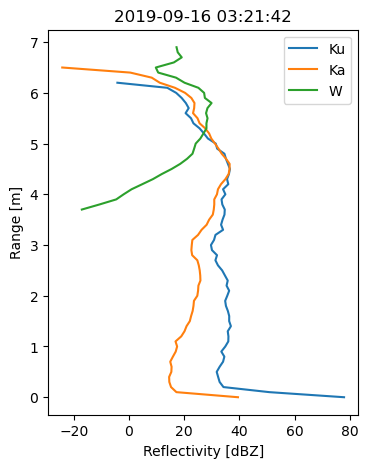

In [6]:
fig, ax = plt.subplots(figsize=(4, 5))
x_ku = ds['lores_zhh14'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
x_ka = ds['lores_zhh35'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
x_w = ds['hi2lo_z95n'].sel(Time='2019-09-16 03:21:42').isel(Time=0)

y = ds.Alt_range.values
ax.plot(x_ku, y, label='Ku')
ax.plot(x_ka, y, label='Ka')
ax.plot(x_w, y, label='W')
ax.set_xlabel("Reflectivity [dBZ]")
ax.set_ylabel("Range [m]")
title = pd.to_datetime(ds.Time.sel(Time='2019-09-16 03:21:42').values[0]).strftime('%Y-%m-%d %X')
ax.set_title(title)
ax.legend();

### Control experiment

Lets create a only one profile by taking the largest reflectivity above 4.4km 

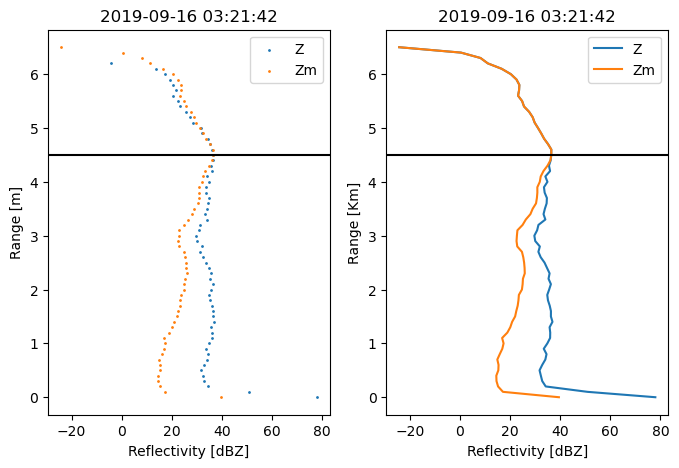

In [7]:
zm = ds['lores_zhh35'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
ze = ds['lores_zhh14'].sel(Time='2019-09-16 03:21:42').isel(Time=0)

zet = xr.zeros_like(zm)
zet[zm.Alt_range <= 4.4] = ze.sel(Alt_range=slice(0, 4.4))
zet[zm.Alt_range > 4.4] = zm.sel(Alt_range=slice(4.5, 8))
zmt =  xr.zeros_like(ze)
zmt[zet.Alt_range <= 4.4] = zm.sel(Alt_range=slice(0, 4.4))
zmt[zet.Alt_range > 4.4] = zm.sel(Alt_range=slice(4.5, 8))

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(8, 5))
y = ds.Alt_range.values
ax.scatter(ze, y, label='Z', s=1)
ax.scatter(zm, y, label='Zm', s=1)
ax.set_xlabel("Reflectivity [dBZ]")
ax.set_ylabel("Range [m]")
ax.axhline(4.5, -25, 80, c='k')
title = pd.to_datetime(ds.Time.sel(Time='2019-09-16 03:21:42').values[0]).strftime('%Y-%m-%d %X')
ax.set_title(title)
ax.legend();

ax1.plot(zet, y, label='Z')
ax1.plot(zmt, y, label='Zm')
ax1.set_xlabel("Reflectivity [dBZ]")
ax1.set_ylabel("Range [Km]")
ax1.axhline(4.5, -25, 80, c='k')
title = pd.to_datetime(ds.Time.sel(Time='2019-09-16 03:21:42').values[0]).strftime('%Y-%m-%d %X')
ax1.set_title(title)
ax1.legend();


## Attenuation PDE

Attenuation is decribe as follows
$$
Z_m  = Z * e^{-0.2ln(10)\int_{0}^{r} k(s)ds}
 \ \ \ \ \ \                  (1)
$$

Hitschfeld and Bordan (1954) suggest that the attenuation can be related to reflectivity using a power-law relationship

$$ 
k = \alpha Z^\beta
 \ \ \ \ \ \ \ (2)
$$ 

#### Attenuation differential equation

substituting (2) into (1) and differentiating with respect to range $\left(d/dr\right)$ gives a first-order differential equation, 
 
$$
\frac{du}{dr} + u\beta \frac{d}{dr} [ln(Z_m)] + q\alpha = 0
 \ \ \ \  \ \ (3)
$$

Where $$u=Z^{-\beta}$$ 
$$q=0.2ln(10)\beta$$

#### Initial conditions

$$
Z(r) = Z_m
$$

#### Boundary condition

$$
Z(r=0) = Z_m(r=0)
$$

$$
Z(r=Surface) = Z_m(Surface_{No \ rain})
$$
The last one is related to the Sea-Surface Reference Technique (SRT)

#### Analytical solution
The analytical solution for this first order differential equation is

$$
Z = \frac{Z_m}{\left[1 - qS(r)\right]^{1/\beta}}
\ \ \ \  \ \ (4)
$$

$S(r)$ is given by

$$
S(r) = \int_{0}^{r}\alpha(s)Z_m^{\beta}(s)ds
$$

## Neural Net

In [8]:

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.net = torch.nn.Sequential(
            nn.Linear(1, 30),
            nn.ReLU(),
            nn.Linear(30, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1)
        )

    def forward(self, x):
        return self.net(x)


def np2th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float32).to(device).reshape(n_samples, -1)

In [9]:
class Net:
    def __init__(self, dr, rmin, rmax, zm_i, z_surf, epochs, alpha=5.47e-3, beta=0.691, loss=nn.MSELoss(),
                 lr=1e-3) -> None:
        self.model = NN().to(device)
        self.rmin = rmin
        self.rmax = rmax
        self.dr = dr
        self.alpha = torch.tensor(alpha, requires_grad=True)
        self.zmi = zm_i
        self.zm = np2th(zm_i).requires_grad_(True).to(device)
        self.beta = beta
        self.iter = 0
        self.epochs = epochs
        self.loss = loss
        self.q = 0.2 * torch.log(torch.tensor(10)) * self.beta
        self.lr = lr

        # comp. domain
        self.r = torch.arange(self.rmin, self.rmax + self.dr, self.dr,
                              dtype=torch.float32).view(-1, 1).requires_grad_(True).to(device)

        # Train data
        self.x_train = self.r

        # Initial condition Z along the profile is equal to Ze
        y_ic = np2th(zm_i)
        # Z at surface is Z(r=surf)
        y_ic[0] = torch.tensor(z_surf)
        # Z at top of the cloud is equal to the Zm 
        y_ic[-1] = torch.tensor(zm_i[-1])
        self.y_train = y_ic.requires_grad_(True).to(device)

        self.adam = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        # Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS)
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr=self.lr,
        )

    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()

        # data loss
        y_pred = self.model(self.x_train)
        loss_data = self.loss(y_pred, self.y_train)

        u = self.model(self.x_train) ** - self.beta
        u = torch.tensor(u, requires_grad=True)
        du_dr = torch.autograd.grad(
            u,
            self.r,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            materialize_grads=True

        )[0]

        dlnZm_dr = np2th(np.gradient(np.log(self.zmi), self.dr))

        # PDE loss
        loss_pde = du_dr + u * self.beta * dlnZm_dr + self.alpha * self.q
        loss_pde = torch.mean(loss_pde ** 2)

        # total loss
        loss = loss_pde + loss_data
        loss.backward()

        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1

        return loss

    def train(self):
        self.model.train()
        for i in range(self.epochs):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

    def eval_(self):
        self.model.eval()

In [10]:
zm = ds['lores_zhh35'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
ze = ds['lores_zhh14'].sel(Time='2019-09-16 03:21:42').isel(Time=0)
zet = xr.zeros_like(zm)
zet[zm.Alt_range <= 4.4] = ze.sel(Alt_range=slice(0, 4.4))
zet[zm.Alt_range > 4.4] = zm.sel(Alt_range=slice(4.5, 8))
zmt = xr.zeros_like(ze)
zmt[zet.Alt_range <= 4.4] = zm.sel(Alt_range=slice(0, 4.4))
zmt[zet.Alt_range > 4.4] = zm.sel(Alt_range=slice(4.5, 8))
zmi = zm.sel(Alt_range=slice(0, 4.4)).values
zs = ze.sel(Alt_range=slice(0, 4.4)).values[0]
zt = zm.sel(Alt_range=slice(0, 4.4)).values[-1]
net = Net(dr=0.1, rmin=0, rmax=4.4, zm_i=zmi, z_surf=zs, lr=1e-3, epochs=5000)


In [11]:
net.train()
net.model.eval()

0 nan
100 110.05894470214844
200 71.85919189453125
300 61.386661529541016
400 44.76682662963867
500 10.82668399810791
600 0.6473228335380554
700 0.37836983799934387
800 0.3336723744869232
900 0.3331829607486725
1000 0.33285826444625854
1100 0.3310222327709198
1200 0.3368757963180542
1300 0.33756688237190247
1400 0.32002636790275574
1500 0.3212108016014099
1600 0.3258707821369171
1700 0.38336390256881714
1800 0.33043116331100464
1900 0.3413707911968231
2000 0.3462793827056885
2100 0.33116084337234497
2200 0.32930639386177063
2300 0.32358378171920776
2400 0.31991082429885864
2500 0.3210029900074005
2600 0.332116037607193
2700 0.3392120897769928
2800 0.3289934992790222
2900 0.3183189332485199
3000 0.3233049511909485
3100 0.35489383339881897
3200 0.31778696179389954
3300 0.35909008979797363
3400 0.3422147333621979
3500 0.3306962251663208
3600 0.3406357169151306
3700 0.34841957688331604
3800 0.32638683915138245
3900 0.3188396394252777
4000 0.3146606683731079
4100 0.3131493330001831
4200 0.3

NN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=50, bias=True)
    (7): ReLU()
    (8): Linear(in_features=50, out_features=50, bias=True)
    (9): ReLU()
    (10): Linear(in_features=50, out_features=30, bias=True)
    (11): ReLU()
    (12): Linear(in_features=30, out_features=20, bias=True)
    (13): ReLU()
    (14): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [12]:
r = torch.arange(0, 4.4 + 0.1, 0.1, dtype=torch.float32).view(-1, 1)
r = r.to(net.r.device)
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(r)
    y_pred = y_pred.cpu().numpy()


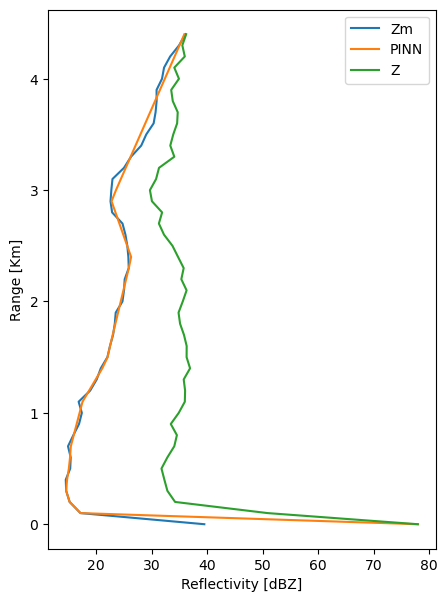

1


In [14]:
fig, ax = plt.subplots(figsize=(5, 7))
ax.plot(zmi, r.cpu(), label='Zm')
ax.plot(y_pred, r.cpu(), label='PINN')
ax.plot(ze.sel(Alt_range=slice(0, 4.4)).values, r.cpu(), label="Z")
ax.set_ylabel("Range [Km]")
ax.set_xlabel("Reflectivity [dBZ]")
ax.legend()
plt.show()
print(1)